# Challenge results analysis

In [131]:
import datetime as dt

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
from sqlalchemy import create_engine

%matplotlib inline

disk_engine = create_engine('sqlite:///data/challenge_2016.sqlite3')

## Summary statistics

In [98]:
conn = disk_engine.connect()

n_schools = conn.execute('SELECT COUNT(c.id) FROM curriculums c').first()[0]
print("Nombre de formations: {}".format(n_schools))

n_teams = conn.execute('SELECT COUNT(t.id) FROM teams t').first()[0]
print("Nombre d'équipes: {}".format(n_teams))

n_participant_teams = conn.execute('SELECT COUNT(DISTINCT(s.team_id)) FROM submissions s').first()[0]
print("Nombre d'équipes ayant soumis: {}".format(n_participant_teams))

n_subs = conn.execute('SELECT COUNT(s.id) FROM submissions s').first()[0]
print('Nombre de soumissions: {}'.format(n_subs))

n_valid_subs = conn.execute('SELECT COUNT(s.id) FROM submissions s WHERE s.valid = 1').first()[0]
print('Nombre de soumissions valides: {}'.format(n_valid_subs))


Nombre de formations: 8
Nombre d'équipes: 60
Nombre d'équipes ayant soumis: 51
Nombre de soumissions: 1209
Nombre de soumissions valides: 947


## Final rankings

In [91]:
df = pd.read_sql_query(
    '''
    SELECT
        t.name as "Team name",
        c.school as School,
        MIN(s.score) as "Best score",
        COUNT(s.id) as "Number of submissions"
    FROM
        persons p,
        submissions s,
        teams t,
        curriculums c
    WHERE
        p.team_id = t.id AND
        c.id = t.curriculum_id AND
        s.by_id = p.id AND
        s.valid = 1
    GROUP BY
        t.id
    ORDER BY
        "Best score"
    ''',
    disk_engine
)

df

,Team name,School,Best score,Number of submissions
0,Dream Team,ISAE - SUPAERO,2.794423,49
1,Mr Nobody,Université de Bordeaux,3.490000,14
2,Oh l'équipe,Université de Bordeaux,3.490000,45
3,PrédiX,Ecole Polytechnique,3.540233,47
4,Louison Bobet,Toulouse School of Economics,3.610000,61
5,Armstrong,INSA,3.620000,35
6,OpenBikes,Université Paul Sabatier,3.629309,7
7,Ravenclaw,Université de Bordeaux,3.670000,64
8,LA ROUE ARRIÈRE,Université Paul Sabatier,3.679264,6
9,WeLoveTheHail,INSA,3.703333,5


## Score and number of submissions

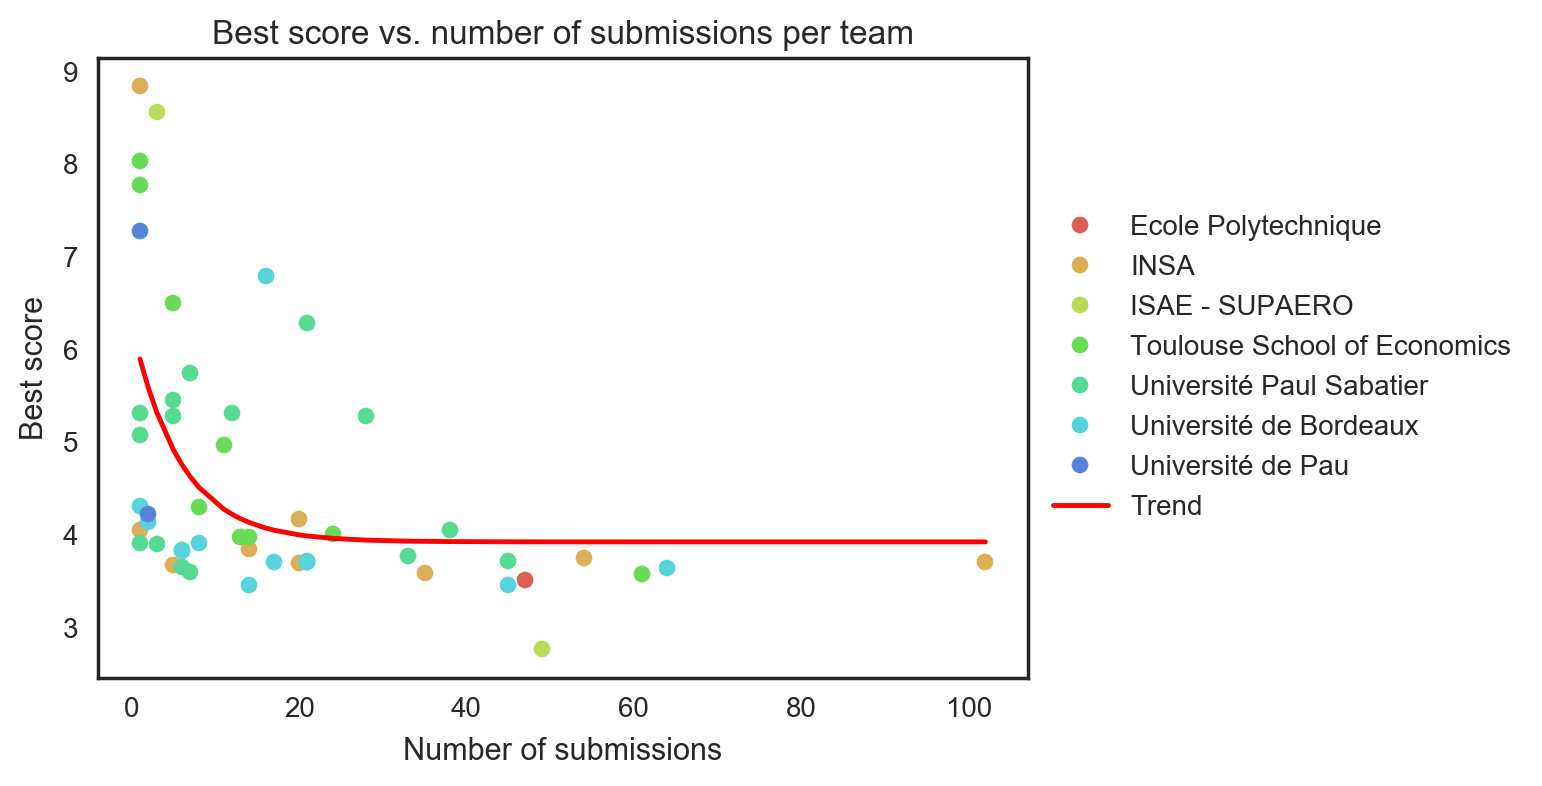

In [88]:
df = pd.read_sql_query(
    '''
    SELECT
        t.name as name,
        c.school as school,
        MIN(s.score) as best_score,
        COUNT(s.id) as n_submissions
    FROM
        persons p,
        submissions s,
        teams t,
        curriculums c
    WHERE
        p.team_id = t.id AND
        c.id = t.curriculum_id AND
        s.by_id = p.id AND
        s.valid = 1
    GROUP BY
        t.id
    ORDER BY
        school
    ''',
    disk_engine
)

sns.set_style('white')
fig, ax = plt.subplots()

for school, group in df.groupby('school'):
    ax.plot(
        group.n_submissions,
        group.best_score,
        marker='o',
        linestyle='',
        ms=6,
        label=school
    )

# Fit an exponential curve
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, _ = curve_fit(func, df['n_submissions'], df['best_score'])
x = df['n_submissions'].sort_values()
y = func(x, *popt)
ax.plot(x, y, 'r-', label='Trend')

ax.margins(0.05)
ax.set_xlabel('Number of submissions')
ax.set_ylabel('Best score')
ax.set_title('Best score vs. number of submissions per team')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Progressive minimum score per team

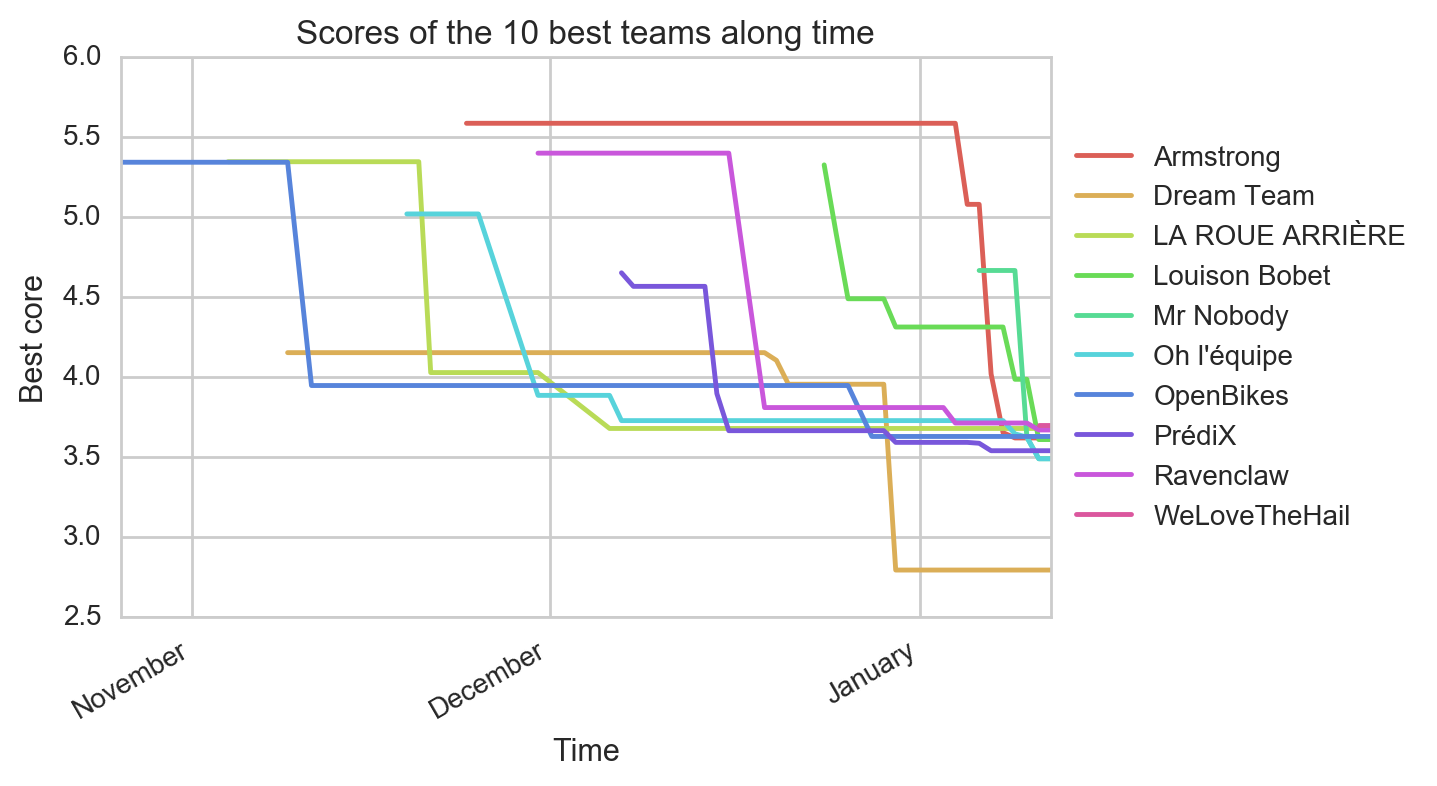

In [149]:
df = pd.read_sql_query(
    '''
    SELECT
        strftime('%Y-%m-%d', s.at) AS date,
        s.score,
        t.name
    FROM
        submissions s,
        teams t
    WHERE
        s.team_id = t.id AND
        s.valid = 1 AND
        s.score < 6 AND
        t.name IN (
            SELECT t.name
            FROM submissions s, teams t
            WHERE s.team_id = t.id
            GROUP BY t.name
            ORDER BY MIN(s.score)
            LIMIT 10
        )
    ''',
    disk_engine
)

df['date'] = df['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

tb = pd.pivot_table(
    data=df,
    values='score',
    index='date',
    columns='name',
    aggfunc=np.min,
    fill_value=np.inf
)

def fill_progressive_min(array):
    for i, v in enumerate(array):
        array[i] = min(array[:i+1])
    return array
    
for col in tb.columns:
    tb[col] = fill_progressive_min(tb[col])
    
sns.set_style('whitegrid')
sns.set_palette('hls', 10)
fig, ax = plt.subplots()

for team, scores in tb.iteritems():
    scores.replace(np.inf, np.nan).dropna().plot(ax=ax, label=team)

months = mdates.MonthLocator()  # every month
month_fmt = mdates.DateFormatter('%B')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
ax.set_xlabel('Time')
ax.set_ylabel('Best score')
ax.set_title('Scores of the 10 best teams along time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Number of submissions along time

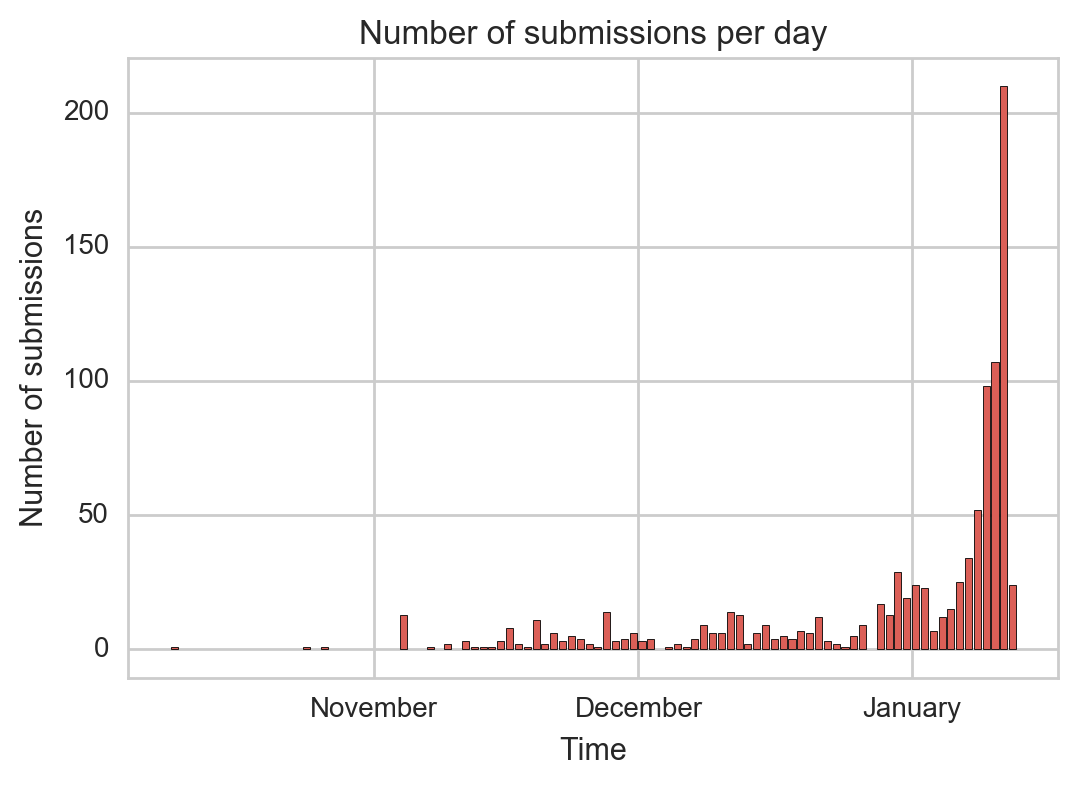

In [153]:
df = pd.read_sql_query(
    '''
    SELECT
        strftime('%Y-%m-%d', s.at) AS date,
        COUNT(s.id) AS n_submissions
    FROM
        submissions s
    WHERE
        s.valid = 1
    GROUP BY
        date
    ''',
    disk_engine
)

df['date'] = df['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

fig, ax = plt.subplots()

ax.bar(df['date'].tolist(), df['n_submissions'].tolist())

ax.margins(0.05)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
ax.set_xlabel('Time')
ax.set_ylabel('Number of submissions')
ax.set_title('Number of submissions per day')